Image Processing and Computer Vision 2021/22

### CAPS INSPECTION
### Project 3_Off_center decoration

Junjie Zhu - junjie.zhu3@studio.unibo.it - 0001030002

Jiacheng Zhang - jiacheng.zhang@studio.unibo.it - 0001038421

Wenxi Huo - wenxi.huo@studio.unibo.it - 0001035935 

In [1]:
# improt necessary libraries/modules for image processing and visualization
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

#### 1. Pre-processing
The images to be detected for this task are three channels RGB images, so after loading the task images from the local file folder, we converts them to RGB format, and separates them into individual red, green, and blue channels by using cv2.split() for future processing.

Loaded 27 images!


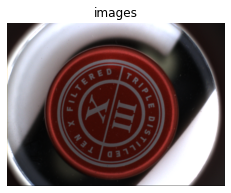

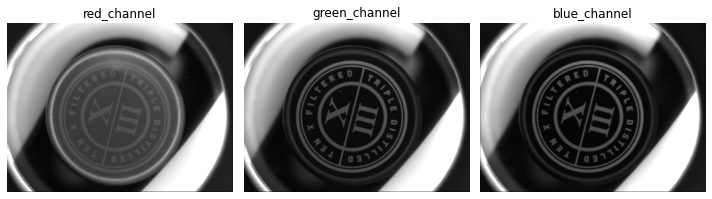

In [2]:
images = [] # List to store original images

# Load images from the local folder path
folder_path = 'cap-inspection-images/project_3_off-center_decoration/'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    if file_path.endswith(('.bmp')):
        # Read and append images converted to RGB format to the 'images' list
        image_org = cv2.imread(file_path)
        images.append(cv2.cvtColor(np.copy(image_org),cv2.COLOR_BGR2RGB))
print('Loaded '+ str(len(images))+ ' images!')


blue_channel = [] # List to store blue channel images
red_channel = [] # List to store red channel images
green_channel = [] # List to store green channel images

for image in images:
    # Get the number of color channels
    channels = image.shape[2] if len(image.shape) == 3 else 1

    if channels == 3: # If the image has three color channels (RGB)
        red, green, blue = cv2.split(image) # Split the channels
        red_channel.append(red)
        blue_channel.append(blue)
        green_channel.append(green)
    else:
        print("Please check the channel of the image!")

# Display the original image and its separate color channels
plt.figure(figsize=(6, 3))    
plt.title('images')    
plt.imshow(images[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.title('red_channel')
plt.imshow(red_channel[0], cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title('green_channel')
plt.imshow(green_channel[0], cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('blue_channel')
plt.imshow(blue_channel[0], cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()   

#### Task: compute the off–center distance
##### 1. Outline the cap and the decoration by generating a circle that fits to the cap 

According to the task information, the image of the cap can be segmented in three parts using the different colors: the decoration is grey, the cap is dark red and the border of the cap is bright red. Therefore, we use the red channel image to detect the cap.

In the red channel image, we can see the border of the cap as a clear bright circle, in order to reduce the background noise as much as possible, we **binarized the red channel image** first, then **Hough Circle Transform** has been used to detect the border circle. The results are shown in blue in the images. 

center of the cap in the first image(d_00):  370 318
diameter of the cap in the first image(d_00):  436


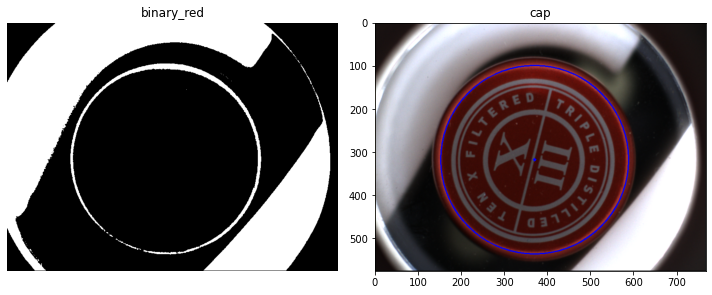

In [22]:
binary_red = [] # List to store thresholded red channel images (binary)
cap = [] # List to store images with detected cap circles
cap_center = [] # List to store detected cap centers (x, y, radius)

for index, re in enumerate(red_channel):
    # Apply a binary threshold to the red channel image
    _, bin_red = cv2.threshold(re, 128, 255, cv2.THRESH_BINARY)
    binary_red.append(bin_red)
#     plt.imshow(bin_red, cmap='gray')
#     plt.show()
    
    # Detect border circle in the binary red channel image using HoughCircles
    cap_circle = cv2.HoughCircles(bin_red, cv2.HOUGH_GRADIENT, dp=1, minDist=500,
                               param1=150,param2=5,minRadius=200,maxRadius=300)

    if cap_circle is not None:
        # Store a copy of the original image with detected circles
        cap.append(np.copy(images[index]))
        cap_circle = np.uint16(np.around(cap_circle))
        
        # Draw circles around the detected cap circles
        for i in cap_circle[0, :]:
            cv2.circle(cap[index], (i[0], i[1]), i[2], (0, 0, 255), 2)
            cv2.circle(cap[index], (i[0], i[1]), 2, (0, 0, 255), 3)
            
        # Store the center coordinates and radius of the detected cap circle
        capc = cap_circle[0][0]
        cap_center.append((int(capc[0]),int(capc[1]),int(capc[2])))  
#         print('center of the cap (x,y): ',cap_center[index][0],cap_center[index][1])
#         print('diameter of the cap: ',cap_center[index][2]*2)
#         plt.imshow(cap[index])
#         plt.show() 
#         namtext = f"cap {file_names[index]}"
#         cv2.imwrite(namtext, cv2.cvtColor(np.copy(cap[index]),cv2.COLOR_BGR2RGB))
    else:
        print("No cap circles or not enough circles detected.") 
        
print('center of the cap in the first image(d_00): ',cap_center[0][0],cap_center[0][1])
print('diameter of the cap in the first image(d_00): ',cap_center[0][2]*2)

# Plot the binary red channel image and the image with detected cap circles
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('binary_red')
plt.imshow(binary_red[0], cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title('cap')
plt.imshow(cap[0], cmap='gray')

plt.tight_layout()
plt.show()

When detecting the decorative center, in this case it is detecting gray objects with red as the background. It is best to use **the green channel** for detection. In RGB images, the green channel has a lower response to red objects because red objects mainly have high brightness in the red channel but show lower brightness in the green channel. Therefore, using the green channel can better distinguish the red cap background and gray decorative objects, thereby helping to detect and segment gray decorations.

First, generate a **mask** based on the previously generated border cap circle to eliminate most of the background interference and only retain the decorated cap. Then, **binarize** the area to extract the decoration. When detecting the decoration center, the outermost contour should be used. Therefore, after performing **contour detection** on the outline of the decorations, the largest contour is found out and filled to obtain a solid circle of the size of the decoration to eliminate the influence of the internal circular structure of the decorations on circle detection.

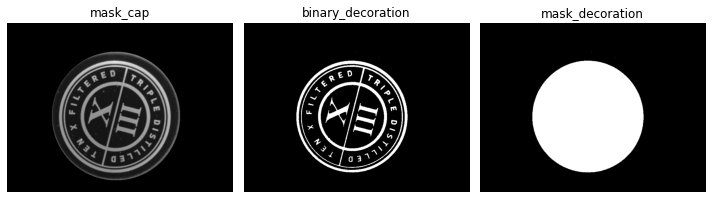

In [28]:
mask_cap =[] # List to store masked cap images
binary_decoration = [] # List to store binary masked cap images
mask_decoration =[] # List to store masked decoration ROIs

for index, gre in enumerate(green_channel):
    
    # Create a mask using the green channel for the cap region
    mask = np.zeros_like(green_channel[index])
    cv2.circle(mask, (cap_center[index][0],cap_center[index][1]), cap_center[index][2], 255, -1)
    mask_cap.append(cv2.bitwise_and(gre,mask))
#     plt.imshow(mask_cap[index], cmap='gray')
#     plt.show()

    # Apply a threshold to the masked region to isolate the decoration
    _, bin_dec = cv2.threshold(mask_cap[index], 65, 255, cv2.THRESH_BINARY)
    binary_decoration.append(bin_dec)
#     plt.imshow(binary_decoration[index], cmap='gray')
#     plt.show()
#     namtext = f"binary_decoration {file_names[index]}"
#     cv2.imwrite(namtext, binary_decoration[index])
    # Find contours in the binary decoration image and draw the contours in the mask
    contours, _ = cv2.findContours(binary_decoration[index], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours is not None:
        binary_dec_copy = np.copy(binary_decoration[index])
        
        # Get the largest contour
        max_contour = max(contours, key=cv2.contourArea) 
        # Draw contours in the mask for decoration
        mask_decoration.append(cv2.drawContours(binary_dec_copy, [max_contour], -1, 255, thickness=cv2.FILLED))
        
#         plt.imshow(mask_dec[index], cmap='gray')
#         plt.show()
    else:
        print("No decoration contours detected.")

# Displaying the cap mask, binary decoration, and mask for decoration
plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.title('mask_cap')
plt.imshow(mask_cap[0], cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title('binary_decoration')
plt.imshow(binary_decoration[0], cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('mask_decoration')
plt.imshow(mask_decoration[0], cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()   

#### Task: compute the off–center distance
##### 2. Outline the decoration by generating a circle that fits the decoration

On the binary image with only decorative outline circles, **Hough circle detection** is applied to obtain the decoration center position information. 

Then we calculate the **Euclidean distance** between the center of the detected decoration (dec_center) and the center of the detected cap (cap_center).

In the following images, the cap circle and center point are in **blue** and the decoration circle and center point is in **green**.

center of the cap in the first image(d_00):  370 318
diameter of the cap in the first image[0](d_00):  436
center of the decoration in the first image(d_00):  366 320
diameter of the decoration in the first image[0](d_00):  376
Off center distance: 4.47


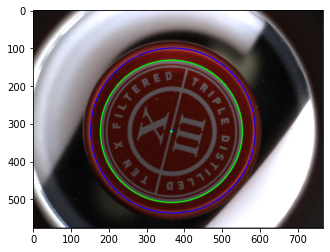

In [30]:
dec = [] # List to store images with detected decoration circles
dec_center = [] # List to store detected decoration centers
off_center_distance = [] # List to store off-center distances

for index, d in enumerate(mask_decoration):
    dec.append(np.copy(cap[index]))
    
    # Detect circles in the decoration mask
    dec_circle = cv2.HoughCircles(d, cv2.HOUGH_GRADIENT, dp=1, minDist=500,
                               param1=100,param2=10,minRadius=180,maxRadius=200)

    if dec_circle is not None:
        dec_circle = np.uint16(np.around(dec_circle))
        
        # Draw detected circles on the copied cap image
        for i in dec_circle[0, :]:
            cv2.circle(dec[index], (i[0], i[1]), i[2], (0, 255, 0), 2)
            cv2.circle(dec[index], (i[0], i[1]), 2, (0, 255, 0), 3)

        decc = dec_circle[0][0]
        dec_center.append((int(decc[0]),int(decc[1]),int(decc[2])))   
#         print('center of the decoration: ',dec_center[index][0],dec_center[index][1])
#         print('diameter of the decoration: ',dec_center[index][2]*2)
    else:
        print("No decoration circles detected.") 
#     plt.imshow(dec[index])
#     plt.show() 
    
    # Calculate the off-center distance between cap and decoration centers
    if dec_center is not None and cap_center is not None:
        dis = np.around(np.sqrt((dec_center[index][0] - cap_center[index][0])**2 + (dec_center[index][1] - cap_center[index][1])**2),2)
        off_center_distance.append(dis)
#         print("Off center distance:",off_center_distance[index])
    else:
        print("Invalid circle centers detected.")

# Display center and diameter information for the first image
print('center of the cap in the first image(d_00): ',cap_center[0][0],cap_center[0][1])
print('diameter of the cap in the first image[0](d_00): ',cap_center[0][2]*2)        
print('center of the decoration in the first image(d_00): ',dec_center[0][0],dec_center[0][1])
print('diameter of the decoration in the first image[0](d_00): ',dec_center[0][2]*2)
print("Off center distance:",off_center_distance[0])

plt.imshow(dec[0])
plt.show()  

All results are shown as follows.

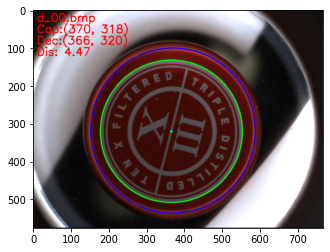

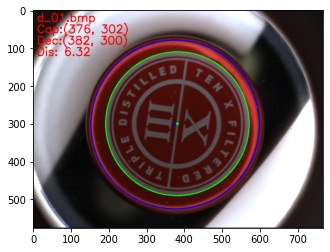

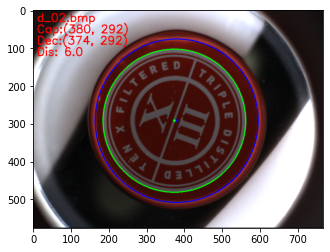

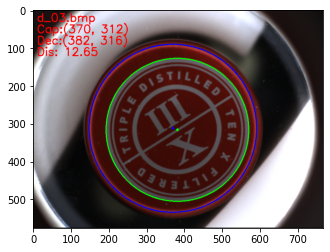

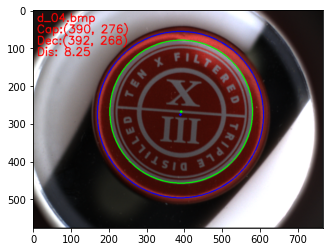

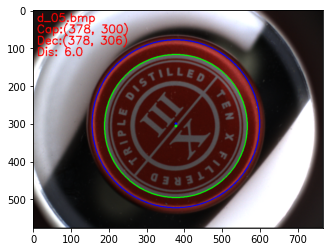

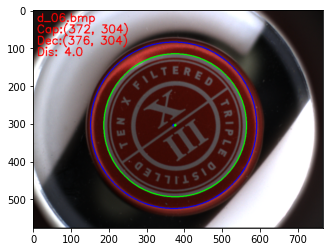

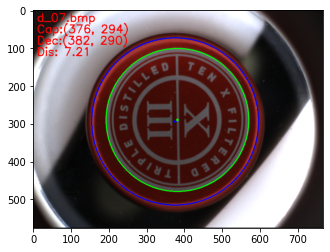

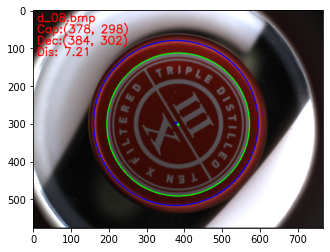

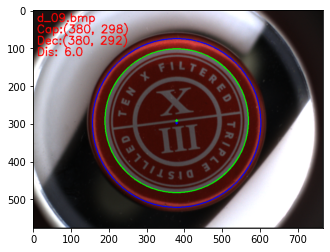

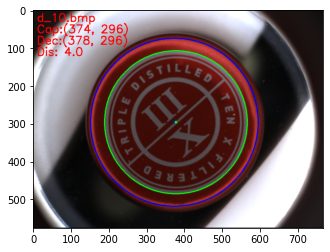

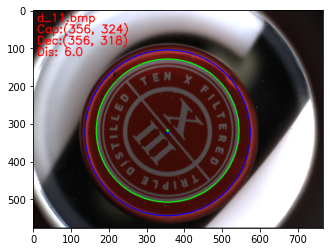

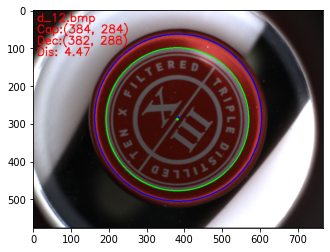

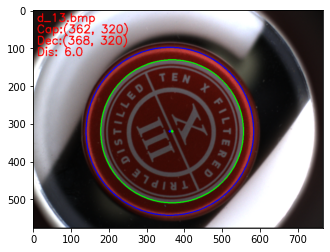

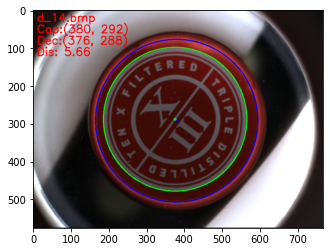

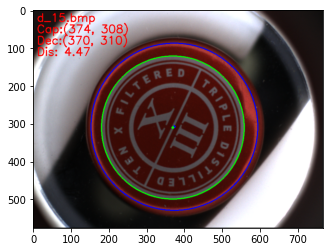

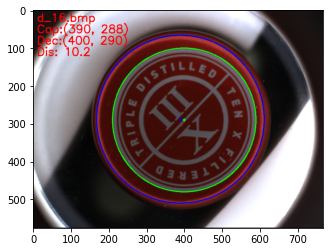

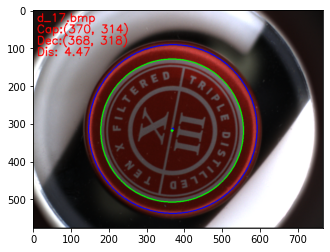

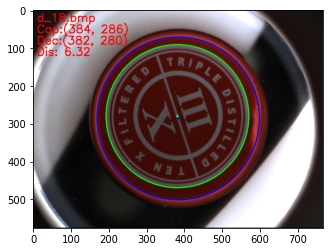

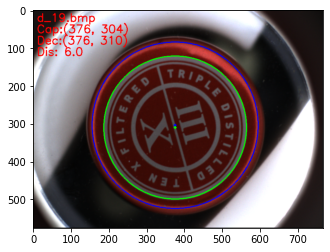

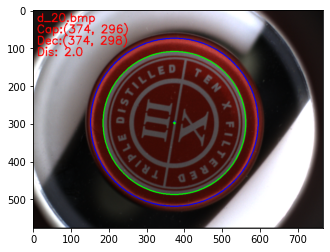

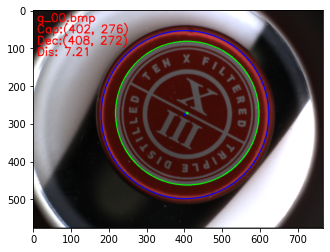

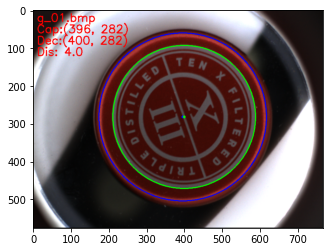

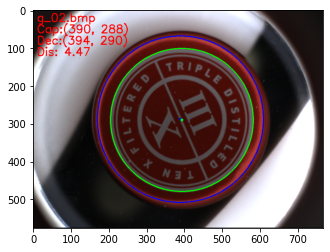

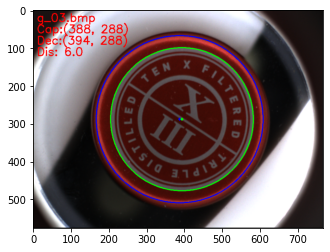

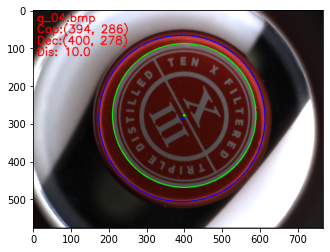

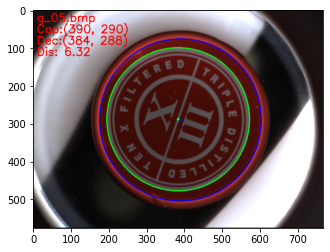

In [32]:
res = [] # List to store annotated images

# Add text annotations to the copied image
for index, dd in enumerate(dec):
    res.append(np.copy(dec[index]))
    cv2.putText(res[index], file_names[index], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
    captext = f"Cap:{cap_center[index][0],cap_center[index][1]}"
    cv2.putText(res[index], captext, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
    dectext = f"Dec:{dec_center[index][0],dec_center[index][1]}"
    cv2.putText(res[index], dectext, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
    distext = f"Dis: {off_center_distance[index]}"
    cv2.putText(res[index], distext, (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
    
    plt.imshow(res[index])
    plt.show() 
    namtext = f"res {file_names[index]}"
    cv2.imwrite(namtext, cv2.cvtColor(np.copy(res[index]),cv2.COLOR_BGR2RGB))

In this project, we have accomplished all the required tasks. Upon obtaining the coordinates of the two center points, we computed the deviation distance between the cap center and the decoration center with an accuracy of 0.01.